# Flow limit

**Goal:** So I have now

1. Trained a flow
2. Looked at the fits in 2b with the preliminary systematic that I defined.

So I think the _next_ order of business is to take this show on the road and just see what a first pass at the limit is.


**Plan of attack** I'm going to get the suite of templates in `bkgPred.py` and then put them together here!

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import pearsonr

from plotUtils import significance

from matplotlib import cm
import numpy as np

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 


from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

import cabinetry
cabinetry.set_logging()

import copy
import json
import pathlib

import boost_histogram as bh
import hist
import pyhf
from pyhf.contrib.utils import download

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Setup the bkg estimate region**

In [5]:
nSeeds = 25
yr='17'

**Parameters that I ran over with:**

`python bkgPred.py -d ../data/RR/cryptotuples/data17.root --ntag 4 --nEvents 10000 --nPreds 1 --flow_config configs/val1.json --subDir data17-MAY21_4b_0of-1_detaCut --tag test4b`

**Copying over some code I had in the `Combine-GP` notebook:**

In [6]:
c = 'val1'

subDir = 'data17-MAY21_4b_0of-1_detaCut'


In [7]:
%%bash
ls ../gp-for-flows/models/data17-MAY21_4b_0of-1_detaCut

nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0


In [8]:
hdict = {} # GP + flow prediction

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)



modelDir = f'../gp-for-flows/models/{subDir}'
modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

# Let's also save some args that might be useful for X and Y
hdict['modelConfig'] = modelConfig

with open(f'{modelDir}/{modelConfig}/hists_gp_10ktest4b.json','r') as hfile:
    out = json.load(hfile)

for k in out.keys():
    hdict[k] = np.array( out[k])

print(modelConfig)

nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0


I guess I could compare this to the rw that Marin trained before the `X_wt` cut?

In [9]:
rwCols = ['event_number', 'pass_vbf_sel', 'ntag', 'njets', 'X_hh', 'kinematic_region',
          'm_hh', 'pt_hh', 'dEta_hh', 'X_wt_tag', 
          'm_h1', 'pT_h1', 'eta_h1', 'phi_h1',
          'm_h2', 'pT_h2', 'eta_h2', 'phi_h2',
          'SR_varName','CVR', 'kinematic_region_Q', 'sr_bin', 'SRout',
          f'NN_d24_weight_bstrap_med_{yr}',
          f'NN_d24_weight_bstrap_IQR_{yr}',
          'rw_to_4b',
          f'NN_d24_weight_VRderiv_bstrap_med_{yr}',
          f'NN_d24_weight_VRderiv_bstrap_IQR_{yr}']

In [10]:
rwDir = '../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt/'

with uproot.open(f'{rwDir}/data{yr}_Xhh_45_NN_100_bootstraps.root') as f:
    rw = f['sig'].arrays(rwCols,library='pd')
    norm     = f['NN_norm_bstrap_med_17'].all_members['fVal']
    norm_VR  = f['NN_norm_bstrap_med_17'].all_members['fVal']
    norm_IQR = f['NN_norm_bstrap_med_17'].all_members['fVal']

In [11]:
rw.head()

event_number  pass_vbf_sel  ntag  njets      X_hh  kinematic_region  \
0     508252169         False     2      4  0.878572                 0   
1    1674514348         False     3      4  1.209840                 0   
2    1674389675         False     2      4  0.814310                 0   
3    1676379083         False     2      4  0.873422                 0   
4    1674703531         False     2      4  1.312457                 0   

         m_hh       pt_hh   dEta_hh  X_wt_tag  ...  SR_varName       CVR  \
0  451.457794  176.753967  1.097103  3.294780  ...    0.878572  0.279504   
1  353.977203   23.365152  0.264315  4.380239  ...    1.209840  0.167723   
2  409.153534   28.264324  1.340291  3.715981  ...    0.814310  0.343911   
3  546.327820   13.967266  1.354123  5.964041  ...    0.873422  0.136031   
4  426.592743   99.812225  0.775797  4.701305  ...    1.312457  0.302413   

   kinematic_region_Q  sr_bin     SRout  NN_d24_weight_bstrap_med_17  \
0                   3       0  0.878572                     0.026934   
1                   1       0  1.209840                     0.970044   
2                   0       0  0.814310                     0.012672   
3                   1       0  0.873422                     0.014112   
4                   1       0  1.312457                     0.019937   

   NN_d24_weight_bstrap_IQR_17  rw_to_4b  NN_d24_weight_VRderiv_bstrap_med_17  \
0                     0.016769     False                             0.026246   
1                     0.070206     False                             0.961878   
2                     0.005002     False                             0.016646   
3                     0.005170     False                             0.013663   
4                     0.008830     False                             0.017467   

   NN_d24_weight_VRderiv_bstrap_IQR_17  
0                             0.016763  
1                             0.055695  
2                             0.004479  
3                             0.004828  
4                             0.007526  

[5 rows x 28 columns]

In [12]:
len(hdict['m_hh_SR_mean'])

50

WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


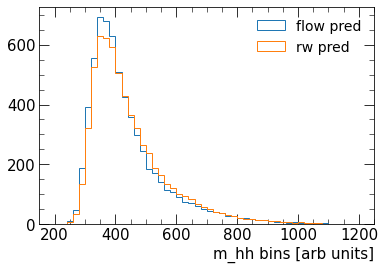

In [13]:
e = np.linspace(200,1200,51)
xx = .5 * (e[1:] + e[:-1])

plt.hist(xx,e,weights=hdict['m_hh_SR_mean'],label='flow pred',histtype='step')


rw_mask = rw.rw_to_4b & (~rw.pass_vbf_sel)
plt.hist(rw.loc[rw_mask,'m_hh'],e,label='rw pred',
         weights=norm*rw.loc[rw_mask,f'NN_d24_weight_bstrap_med_{yr}'],histtype='step')


plt.xlabel('m_hh bins [arb units]',ha='right',x=1)
plt.legend()

**Mini-step:** I think it would be a lot of fun to just get a limit at this point (pre-Xwt cut)!!

In [10]:
h_stack = np.vstack([hdict[f'm_hh_SR_{i}'][3:] for i in range(nSeeds)])

In [11]:
h_stack.shape

(25, 47)

In [13]:
lmbda, u = getEigenvariations(h_stack)

WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


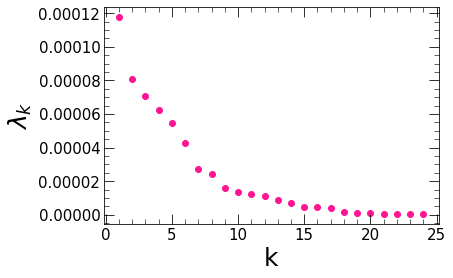

In [14]:
plt.scatter(range(1,nSeeds),lmbda[:nSeeds-1],color='deeppink')
plt.xlabel('k',fontsize=25)
plt.ylabel('$\lambda_k$',fontsize=25)
plt.show()

**Load the model into cabinetry**

note to self - it would be nice to functionify this toooooo!

In [15]:
nVar = 10

In [16]:
L = get_lumi(yr)
L

43.65

In [17]:
config = {
   "General":{
      "Measurement": "ggF_2b_fit",
      "POI": "Signal_norm",               # parameter of interest, which we want to measure 
      "InputPath": "../{SamplePath}",     # where to find input data
      "HistogramFolder": "hists17_m_hh_incl/"

   }
}

In [18]:
config.update({ "Regions": [
                   {'Name':  f"SR_{yr}",
                    #"Filter": sel, <- This is where the categorizatio would go             
                    "Variable": "m_hh",            
                    "Binning": list(e[3:])
                   } ] 
              }
             )

In [19]:
s=10

In [38]:
config.update({
   "Samples":[
      {
         "Name": "Data",
         "Tree": "sig",
         "SamplePath": "data/RR/cryptotuples/data17.root",
          "Filter" : f"(ntag >= 4) & (dEta_hh < 1.5)" , # I will reset this later anyways
         "Data": True  # observed data is handled differently, need to distinguish
      },
      {
         "Name": "Signal",
         "Tree": "sig",
         "Filter": f"(ntag >= 4) & (dEta_hh < 1.5)" ,
         "SamplePath": "../hh4b/hh4b-resolved-reconstruction/SMNR_pythia_mc16d.root",
         "Weight": f"{s*L} * mc_sf"
      },
      {
         "Name": "Background",
         "Tree": "sig",
         "Filter": f"(ntag >= 4) & (dEta_hh < 1.5)", # I will reset this later anyways
         "SamplePath": "data/RR/cryptotuples/data17.root",
      }
   ]
})

In [39]:
# Set the poi
config.update({
   "NormFactors":[
      {
         "Name": "Signal_norm",
         "Samples": "Signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [-5, 10],
      }
   ]
})

In [40]:
# Create a syst histogram, but just fill it with a dummy value
syst_list = [
        {
            "Name": f"bootstraps_eigen{i}",
            "Samples": "Background",
            "Up": {"Tree":  "sig",
                   "Weight": "0.9"},
            "Down": {"Symmetrize": True},
             "Type": "NormPlusShape"
        }
        for i in range(nVar)]

config.update({ "Systematics": syst_list })

In [41]:
cabinetry.templates.build(config, method='uproot')

DEBUG - cabinetry.route -   in region SRin_eta_0_0p5
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - SRin_eta_0_0p5_Data has empty bins: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
DEBUG - cabinetry.histo - saving histogram to hists17_m_hh_cats/SRin_eta_0_0p5_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to hists17_m_hh_cats/SRin_eta_0_0p5_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - SRin_eta_0_0p5_Background has empty bins: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
DEBUG - cabinetry.histo - saving histogram to hists17_m_hh_cats/SRin_eta_0_0p5_Background.npz
DEBUG - cabinetry.route -       variation bootstraps_eigen0 Up
WARNING - cabinetry.histo - SRin_eta_0_0p5_Background_bootstraps_eigen0_Up h

In [42]:
config['General']['HistogramFolder']

'hists17_m_hh_cats/'

In [43]:
%%bash
ls hists17_m_hh_incl

SR_17_Background.npz
SR_17_Background_bootstraps_eigen0_Down.npz
SR_17_Background_bootstraps_eigen0_Up.npz
SR_17_Background_bootstraps_eigen1_Down.npz
SR_17_Background_bootstraps_eigen1_Up.npz
SR_17_Background_bootstraps_eigen2_Down.npz
SR_17_Background_bootstraps_eigen2_Up.npz
SR_17_Background_bootstraps_eigen3_Down.npz
SR_17_Background_bootstraps_eigen3_Up.npz
SR_17_Background_bootstraps_eigen4_Down.npz
SR_17_Background_bootstraps_eigen4_Up.npz
SR_17_Background_bootstraps_eigen5_Down.npz
SR_17_Background_bootstraps_eigen5_Up.npz
SR_17_Background_bootstraps_eigen6_Down.npz
SR_17_Background_bootstraps_eigen6_Up.npz
SR_17_Background_bootstraps_eigen7_Down.npz
SR_17_Background_bootstraps_eigen7_Up.npz
SR_17_Background_bootstraps_eigen8_Down.npz
SR_17_Background_bootstraps_eigen8_Up.npz
SR_17_Background_bootstraps_eigen9_Down.npz
SR_17_Background_bootstraps_eigen9_Up.npz
SR_17_Data.npz
SR_17_Signal.npz


In [44]:
norm

NameError: name 'norm' is not defined

In [ ]:
h_mean = np.mean(h_stack,axis=0)
h_std  = np.sum( (h_mean.reshape(1,-1)- h_stack)**2 , axis=0) / (nSeeds-1)

N = h_mean.sum()
print(N)

histFolder = config['General']['HistogramFolder']
cat_name = 'SR_17'

fname = f'{histFolder}/{cat_name}_Data.npz'
np.savez_compressed(fname, 
                    yields=h_mean, 
                    stdev=np.sqrt(h_mean/nSeeds),
                    bins=e[3:])

fname = f'{histFolder}/{cat_name}_Background.npz'
np.savez_compressed(fname, 
                    yields=h_mean, 
                    stdev=np.sqrt(h_mean/nSeeds),
                    bins=e[3:])

for j in range(nVar):

    var_j = N*np.sqrt(lmbda[j]) * u[:,j]
    #print(var_j)
    
    fname = f'{histFolder}/{cat_name}_Background_bootstraps_eigen{j}_Up.npz'
    np.savez_compressed(fname, 
                        yields=(h_mean+var_j), 
                        stdev=np.sqrt(h_std/nSeeds),
                        bins=e[3:])

    fname = f'{histFolder}/{cat_name}_Background_bootstraps_eigen{j}_Down.npz'
    np.savez_compressed(fname,
                        yields=(h_mean-var_j), 
                        stdev=np.sqrt(h_std/nSeeds),
                        bins=e[3:])

In [ ]:
h_std

**Get the pulls**

In [ ]:
ws = cabinetry.workspace.build(config)

In [ ]:
model, data = cabinetry.model_utils.model_and_data(ws)

In [ ]:
fit_results = cabinetry.fit.fit(model, data)

In [ ]:
cabinetry.visualize.pulls(fit_results)

In [ ]:
prefit  = cabinetry.model_utils.prediction(model,label='prefit') 
postfit = cabinetry.model_utils.prediction(model,label='postfit', fit_results=fit_results)

In [ ]:
cabinetry.visualize.data_mc(prefit, data)

In [ ]:
cabinetry.visualize.data_mc(postfit, data)

**next: Get the upper limit**

In [ ]:
limit_results = cabinetry.fit.limit(model, data)
cabinetry.visualize.limit(limit_results)

In [ ]:
limit_results.expected_limit * s

### Next: m_hh in cats

I wasn't sure if I needed to increase the # of samples for sensible predictions, so I tried it out.

`python bkgPred.py -d ../data/RR/cryptotuples/data17.root --ntag 4 --nEvents 100000 --flow_config configs/val1.json --subDir data17-MAY21_4b_0of-1_detaCut --vbfCut 2 --tag _25_bins --nbinsx 25 --nbinsy 25`


Origially I had run this cmd with `--tag _4b_cats` and this gave me an upper limit of approximately 40 for 2017.

In [2]:
from bkgPred import mhh_bins,Xhh_bins,dEta_bins, d_cols, edg_3d

In [3]:
nEvents = 100000
#nPreds = 10 - it doesn't matter how many preds I pass if I'm passing the nEvents argument.

In [20]:
hdict = {} # GP + flow prediction

# Let's also save some args that might be useful for X and Y
hdict['modelConfig'] = modelConfig

with open(f'{modelDir}/{modelConfig}/hists_gp_100k_25_bins.json','r') as hfile:
    out = json.load(hfile)

for k in out.keys():
    hdict[k] = np.array( out[k])

# print(modelConfig)

In [21]:
h_stack = np.vstack([hdict[f'X_hh_dEta_hh_m_hh_SR_{i}'] for i in range(nSeeds)])

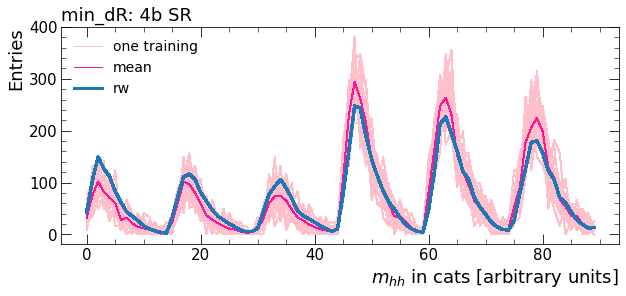

In [22]:
plt.figure(figsize=(10,4))
for i,hi in enumerate(h_stack):
    plt.plot(hi,color='pink',lw=1,
             label='one training' if i == 0 else None)

h_mean = np.mean(h_stack,axis=0)

h_std = np.sqrt(np.sum((h_stack-h_mean.reshape(1,-1))**2,axis=0) / (nSeeds - 1))

plt.plot(h_mean,color='deeppink',label='mean',lw=1)   

rw_mask = rw.rw_to_4b #& (~rw.pass_vbf_sel)
h_rw = np.histogramdd(rw.loc[rw_mask,d_cols].values,edg_3d,
                     weights=norm*rw.loc[rw_mask,f'NN_d24_weight_bstrap_med_{yr}'])[0]
plt.plot(h_rw.flatten(),label='rw')

plt.xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
plt.ylabel('Entries',y=1,ha='right',fontsize=18)
plt.title(f'min_dR: 4b SR',x=0,loc='left')

plt.legend()
#plt.xlim(0,90)
#plt.savefig(f'{figDir}/m_hh_cats_{nSeeds}seeds.pdf',bbox_inches='tight')
plt.show()

In [16]:
h_mean.sum()

6362.191423222296

In [49]:
h_rw.sum()

NameError: name 'h_rw' is not defined

In [50]:
lmbda,u = getEigenvariations(h_stack)

Text(0.5, 0, '$k$')

WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


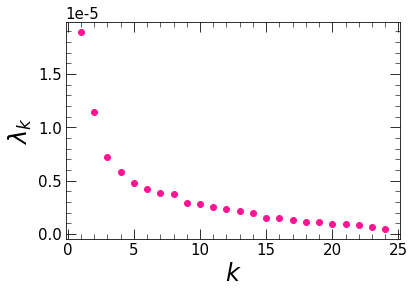

In [51]:
plt.scatter(range(1,nSeeds),lmbda[:nSeeds-1],color='deeppink')
plt.ylabel('$\lambda_k$',fontsize=24)
plt.xlabel('$k$',fontsize=24)

In [52]:
config = {
   "General":{
      "Measurement": "ggF_4b_cats",
      "POI": "Signal_norm",               # parameter of interest, which we want to measure 
      "InputPath": "../{SamplePath}",     # where to find input data
      "HistogramFolder": f"hists{yr}_m_hh_cats/"

   }
}

In [53]:
regions = []

for sr,xmin,xmax in zip(['in','out'],Xhh_bins[:-1],Xhh_bins[1:]) :
    for emin, emax in zip(dEta_bins[:-1],dEta_bins[1:]):
    
        sel  = f"(dEta_hh > {emin}) & (dEta_hh < {emax})"
        sel += f" & (X_hh > {xmin}) & (X_hh < {xmax})"


        reg_dict = {'Name':  f"SR{sr}_eta_{emin}_{emax}".replace(".","p"),
                    "Filter": sel,            
                    "Variable": "m_hh",            
                    "Binning": list(mhh_bins)
                   }
        
        regions.append(reg_dict)
        
config.update({ "Regions":regions })

In [54]:
s=10
s

10

In [55]:
sel = "(ntag >= 4)"

config.update({
   "Samples":[
      {
         "Name": "Data",
         "Tree": "sig",
         "SamplePath": "data/RR/cryptotuples/data17.root",
          "Filter" : sel,
         "Data": True  # observed data is handled differently, need to distinguish
      },
      {
         "Name": "Signal",
         "Tree": "sig",
         "Filter": sel ,
         "SamplePath": "../hh4b/hh4b-resolved-reconstruction/SMNR_pythia_mc16d.root",
         "Weight": f"{s*L} * mc_sf"
      },
      {
         "Name": "Background",
         "Tree": "sig",
         "Filter": sel,
         "SamplePath": "data/RR/cryptotuples/data17.root",
      }
   ]
})

In [56]:
nVar=10

In [57]:
# Set the poi
config.update({
   "NormFactors":[
      {
         "Name": "Signal_norm",
         "Samples": "Signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [-5, 10],
      }
   ]
})


# Create a syst histogram, but just fill it with a dummy value
syst_list = [
        {
            "Name": f"bootstraps_eigen{i}",
            "Samples": "Background",
            "Up": {"Tree":  "sig",
                   "Weight": "0.9"},
            "Down": {"Symmetrize": True},
             "Type": "NormPlusShape"
        }
        for i in range(nVar)]

config.update({ "Systematics": syst_list })

In [58]:
cabinetry.templates.build(config, method='uproot')

DEBUG - cabinetry.route -   in region SRin_eta_0_0p5
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - SRin_eta_0_0p5_Data has empty bins: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
DEBUG - cabinetry.histo - saving histogram to hists17_m_hh_cats/SRin_eta_0_0p5_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to hists17_m_hh_cats/SRin_eta_0_0p5_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - SRin_eta_0_0p5_Background has empty bins: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
DEBUG - cabinetry.histo - saving histogram to hists17_m_hh_cats/SRin_eta_0_0p5_Background.npz
DEBUG - cabinetry.route -       variation bootstraps_eigen0 Up
WARNING - cabinetry.histo - SRin_eta_0_0p5_Background_bootstraps_eigen0_Up h

In [59]:
norms = {'SR': 5121.039629382112, 'VR': 9047.162807259088, 'CR': 19292.019524527317}

In [60]:
norms['SR']

5121.039629382112

In [61]:
N = h_mean.sum()
N

6362.191423222296

In [62]:
6699

6699

In [63]:
h_rw.sum()

NameError: name 'h_rw' is not defined

In [64]:
h_mean = np.mean(h_stack,axis=0)
h_std  = np.sum( (h_mean.reshape(1,-1)- h_stack)**2 , axis=0) / (nSeeds-1)

histFolder = config['General']['HistogramFolder']
for i, reg_dict in enumerate(regions):
    
    cat_name = reg_dict['Name']

    fname = f'{histFolder}/{cat_name}_Data.npz'
    np.savez_compressed(fname, 
                        yields=h_mean[i*15 : (i+1)*15], 
                        stdev=np.sqrt(h_mean[i*15 : (i+1)*15]),
                        bins=mhh_bins)

    fname = f'{histFolder}/{cat_name}_Background.npz'
    np.savez_compressed(fname, 
                        yields=h_mean[i*15 : (i+1)*15], 
                        stdev=1e-4 * np.ones(15), #np.sqrt(h_mean[i*15 : (i+1)*15]/nSeeds),
                        bins=mhh_bins)

    for j in range(nVar):

        var_j = N*np.sqrt(lmbda[j]) * u[:,j]

        fname = f'{histFolder}/{cat_name}_Background_bootstraps_eigen{j}_Up.npz'
        np.savez_compressed(fname, 
                            yields=(h_mean+var_j)[i*15 : (i+1)*15], 
                            stdev=np.sqrt(h_std[i*15 : (i+1)*15]/nSeeds),
                            bins=mhh_bins)

        fname = f'{histFolder}/{cat_name}_Background_bootstraps_eigen{j}_Down.npz'
        np.savez_compressed(fname,
                            yields=(h_mean-var_j)[i*15 : (i+1)*15], 
                            stdev=np.sqrt(h_std[i*15 : (i+1)*15]/nSeeds),
                            bins=mhh_bins)

**Best fit model**

In [65]:
ws = cabinetry.workspace.build(config)
model, data = cabinetry.model_utils.model_and_data(ws)

fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram hists17_m_hh_cats/SRin_eta_0_0p5_Signal_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor Signal_norm to sample Signal in region SRin_eta_0_0p5
WARNING - cabinetry.histo - the modified histogram hists17_m_hh_cats/SRin_eta_0_0p5_Background_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys bootstraps_eigen0 to sample Background in region SRin_eta_0_0p5
WARNING - cabinetry.histo - the modified histogram hists17_m_hh_cats/SRin_eta_0_0p5_Background_bootstraps_eigen0_Up_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
WARNING - cabinetry.histo - the modified histogram hists17_m_hh_cats/SRin_eta_0_0p5_Background_modified.npz does not exist
WAR

/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
DEBUG - cabinetry.visualize.utils - saving figure as figures/pulls.pdf
WARNING - fontTools.ttLib.tables._h_e_a_d - 'created' timestamp seems very low; regarding as unix timestamp
WARNING - fontTools.ttLib.tables._h_e_a_d - 'modified' timestamp seems very low; regarding as unix timestamp


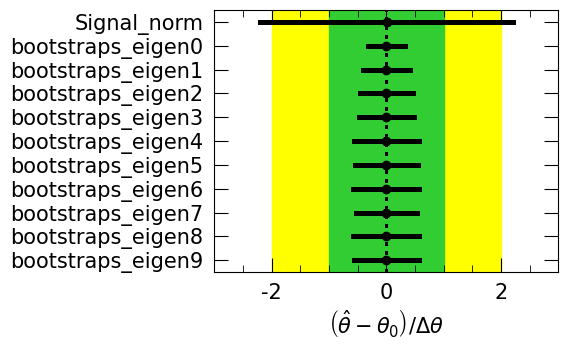

In [66]:
cabinetry.visualize.pulls(fit_results)

In [67]:
prefit  = cabinetry.model_utils.prediction(model,label='prefit') 
postfit = cabinetry.model_utils.prediction(model,label='postfit', fit_results=fit_results)

DEBUG - cabinetry.model_utils - total stdev is [[4.42, 7.53, 8.69, 6.65, 8.68, 3.78, 4.85, ... 3.53, 2.84, 3.52, 2.11, 2.02, 2.91]]
DEBUG - cabinetry.model_utils - total stdev per channel is [26.2, 19.4, 23.5, 44.5, 19.1, 34.4]
DEBUG - cabinetry.model_utils - total stdev is [[1.74, 3.31, 4.34, 3.78, 4.36, 2.64, 2.48, ... 1.59, 1.55, 1.52, 1.27, 1.13, 1.54]]
DEBUG - cabinetry.model_utils - total stdev per channel is [17.6, 14, 13.2, 21.9, 14.6, 15.9]


DEBUG - cabinetry.visualize.utils - saving figure as figures/SRin_eta_0_0p5_prefit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRin_eta_0p5_1_prefit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRin_eta_1_1p5_prefit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRout_eta_0_0p5_prefit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRout_eta_0p5_1_prefit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRout_eta_1_1p5_prefit.pdf


[{'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRin_eta_0_0p5'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRin_eta_0p5_1'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRin_eta_1_1p5'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRout_eta_0_0p5'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRout_eta_0p5_1'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRout_eta_1_1p5'}]

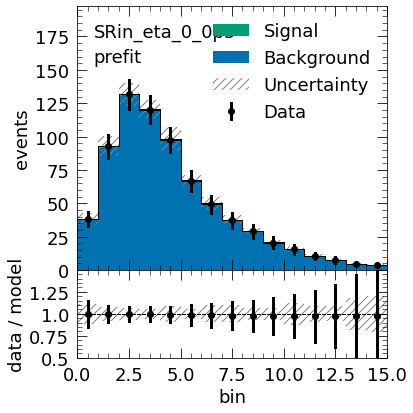

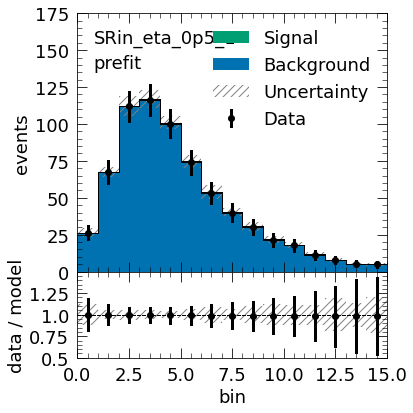

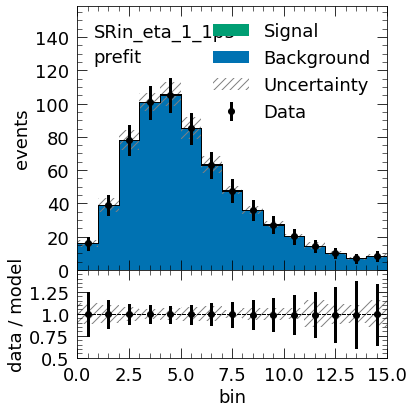

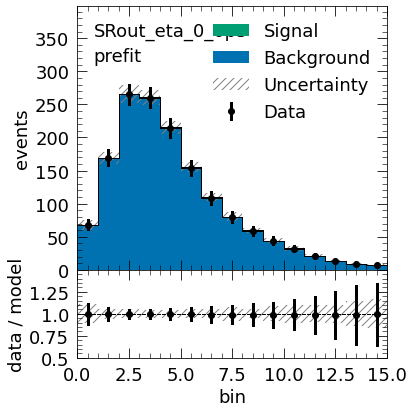

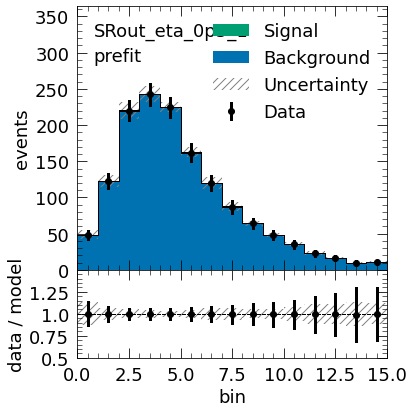

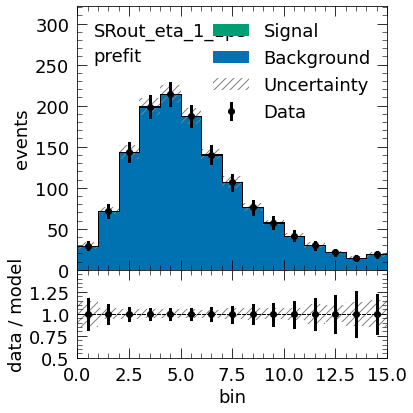

In [68]:
cabinetry.visualize.data_mc(prefit, data)

DEBUG - cabinetry.visualize.utils - saving figure as figures/SRin_eta_0_0p5_postfit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRin_eta_0p5_1_postfit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRin_eta_1_1p5_postfit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRout_eta_0_0p5_postfit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRout_eta_0p5_1_postfit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SRout_eta_1_1p5_postfit.pdf


[{'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRin_eta_0_0p5'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRin_eta_0p5_1'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRin_eta_1_1p5'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRout_eta_0_0p5'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRout_eta_0p5_1'},
 {'figure': <Figure size 432x432 with 2 Axes>, 'region': 'SRout_eta_1_1p5'}]

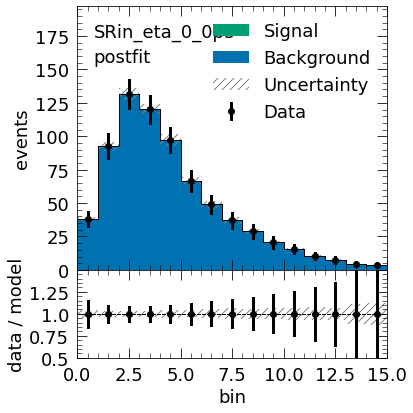

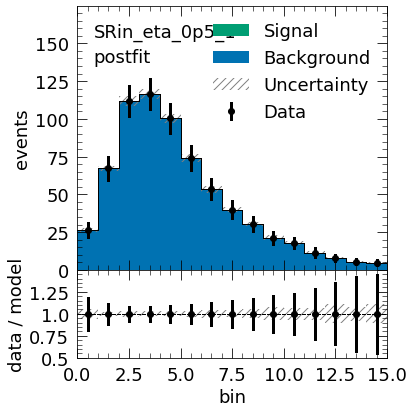

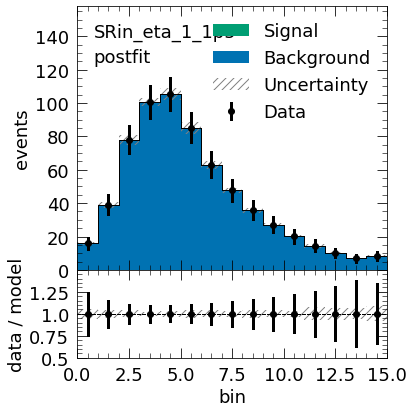

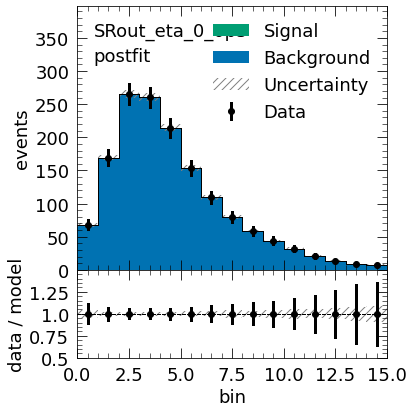

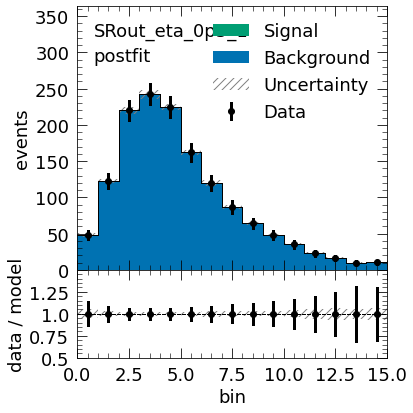

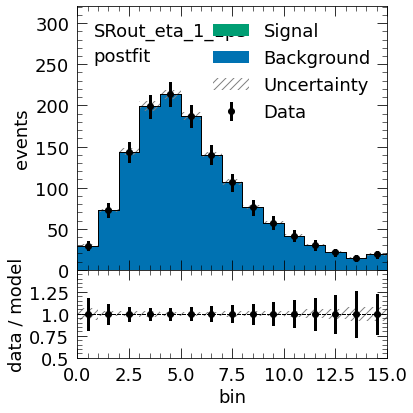

In [69]:
cabinetry.visualize.data_mc(postfit, data)

**Limit**

In [70]:
limit_results = cabinetry.fit.limit(model, data)

INFO - cabinetry.fit - calculating upper limit for Signal_norm
DEBUG - cabinetry.fit - setting lower parameter bound for POI to 0
INFO - cabinetry.fit - determining observed upper limit


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 0.1000, observed CLs = 0.9655


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 10.0000, observed CLs = 0.0000


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 9.4876, observed CLs = 0.0001


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 4.7938, observed CLs = 0.0393


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 3.5778, observed CLs = 0.1225


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 4.6374, observed CLs = 0.0461


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 4.5511, observed CLs = 0.0502


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 4.5561, observed CLs = 0.0500
INFO - cabinetry.fit - successfully converged after 8 steps
INFO - cabinetry.fit - observed upper limit: 4.5561
INFO - cabinetry.fit - determining expected -2 sigma upper limit
DEBUG - cabinetry.fit - Signal_norm = 0.1000, expected -2 sigma CLs = 0.9018 (cached)
DEBUG - cabinetry.fit - Signal_norm = 3.5778, expected -2 sigma CLs = 0.0086 (cached)


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 3.4168, expected -2 sigma CLs = 0.0112


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 1.7584, expected -2 sigma CLs = 0.1255


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 2.8540, expected -2 sigma CLs = 0.0267


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 2.2091, expected -2 sigma CLs = 0.0680


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 2.4905, expected -2 sigma CLs = 0.0456


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 2.4355, expected -2 sigma CLs = 0.0494


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 2.4267, expected -2 sigma CLs = 0.0500
INFO - cabinetry.fit - successfully converged after 9 steps
INFO - cabinetry.fit - expected -2 sigma upper limit: 2.4267
INFO - cabinetry.fit - determining expected -1 sigma upper limit
DEBUG - cabinetry.fit - Signal_norm = 2.8540, expected -1 sigma CLs = 0.0801 (cached)
DEBUG - cabinetry.fit - Signal_norm = 3.4168, expected -1 sigma CLs = 0.0419 (cached)


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 3.2973, expected -1 sigma CLs = 0.0483


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 3.2668, expected -1 sigma CLs = 0.0500


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 3.2718, expected -1 sigma CLs = 0.0497
INFO - cabinetry.fit - successfully converged after 5 steps
INFO - cabinetry.fit - expected -1 sigma upper limit: 3.2668
INFO - cabinetry.fit - determining expected upper limit
DEBUG - cabinetry.fit - Signal_norm = 4.5511, expected CLs = 0.0502 (cached)
DEBUG - cabinetry.fit - Signal_norm = 4.5561, expected CLs = 0.0500 (cached)
INFO - cabinetry.fit - successfully converged after 2 steps
INFO - cabinetry.fit - expected upper limit: 4.5561
INFO - cabinetry.fit - determining expected +1 sigma upper limit
DEBUG - cabinetry.fit - Signal_norm = 4.7938, expected +1 sigma CLs = 0.1716 (cached)
DEBUG - cabinetry.fit - Signal_norm = 9.4876, expected +1 sigma CLs = 0.0015 (cached)


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 8.1492, expected +1 sigma CLs = 0.0081


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 6.4715, expected +1 sigma CLs = 0.0459


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 6.3219, expected +1 sigma CLs = 0.0525


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 6.3783, expected +1 sigma CLs = 0.0499


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 6.3733, expected +1 sigma CLs = 0.0501
INFO - cabinetry.fit - successfully converged after 7 steps
INFO - cabinetry.fit - expected +1 sigma upper limit: 6.3783
INFO - cabinetry.fit - determining expected +2 sigma upper limit
DEBUG - cabinetry.fit - Signal_norm = 8.1492, expected +2 sigma CLs = 0.0730 (cached)
DEBUG - cabinetry.fit - Signal_norm = 9.4876, expected +2 sigma CLs = 0.0223 (cached)


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 8.7570, expected +2 sigma CLs = 0.0440


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 8.6313, expected +2 sigma CLs = 0.0491


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 8.6090, expected +2 sigma CLs = 0.0500


W VariableMetricBuilder No improvement in line search


DEBUG - cabinetry.fit - Signal_norm = 8.6140, expected +2 sigma CLs = 0.0498
INFO - cabinetry.fit - successfully converged after 6 steps
INFO - cabinetry.fit - expected +2 sigma upper limit: 8.6090
INFO - cabinetry.fit - total of 37 steps to calculate all limits
INFO - cabinetry.fit - summary of upper limits:
INFO - cabinetry.fit - observed         : 4.5561
INFO - cabinetry.fit - expected -2 sigma: 2.4267
INFO - cabinetry.fit - expected -1 sigma: 3.2668
INFO - cabinetry.fit - expected         : 4.5561
INFO - cabinetry.fit - expected +1 sigma: 6.3783
INFO - cabinetry.fit - expected +2 sigma: 8.6090


In [71]:
s

10

In [72]:
limit_results.expected_limit*s

array([24.26695029, 32.66758456, 45.56063245, 63.78323406, 86.09034086])

In [73]:
# cabinetry.visualize.limit(limit_results)

In [37]:
s

10